# ベイズA/Bテスト（二項分布）

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class ab_testing_binomial:
    """
    二項分布に従うデータのA/Bテストを実行する。
    Parameters
    ----------
    n_trials: int
        二項分布における試行回数。
    n_occurs: int
        二項分布における生起回数。
    """
    def __init__(self,
                 n_trials_A: int, n_occurs_A: int,
                 n_trials_B: int, n_occurs_B: int,
                 beta_param_a: float, beta_param_b: float, n_sampling: int):
        self.n_trials_A = n_trials_A
        self.n_occurs_A = n_occurs_A
        self.n_trials_B = n_trials_B
        self.n_occurs_B = n_occurs_B
        self.beta_param_a = beta_param_a
        self.beta_param_b = beta_param_b
        self.n_sampling = n_sampling
        self.post_beta_info = None
        
    def posterior_beta(self) -> dict:
        """
        二項分布の生起確率を共役事前分布（ベータ分布）で計算する。
        Parameters
        ----------        
        n_sampling: int
            生起確率のサンプリング数。

        Returns
        -------
        post_beta: list of float
            生起確率のサンプリング結果。
        """
        post_beta_param_a_data_A = self.beta_param_a + self.n_occurs_A
        post_beta_param_b_data_A = self.beta_param_b + self.n_trials_A - self.n_occurs_A
        post_beta_param_a_data_B = self.beta_param_a + self.n_occurs_B
        post_beta_param_b_data_B = self.beta_param_b + self.n_trials_B - self.n_occurs_B
        post_beta_A = sp.stats.beta(post_beta_param_a_data_A, post_beta_param_b_data_A)
        post_beta_B = sp.stats.beta(post_beta_param_a_data_B, post_beta_param_b_data_B)
        post_beta_info = {
            'post_beta_A': post_beta_A.rvs(self.n_sampling),
            'post_beta_B': post_beta_B.rvs(self.n_sampling),
            'mean_A': self._mean(post_beta_param_a_data_A, post_beta_param_b_data_A),
            'mean_B': self._mean(post_beta_param_a_data_B, post_beta_param_b_data_B),
            'var_A': self._var(post_beta_param_a_data_A, post_beta_param_b_data_A),
            'var_B': self._var(post_beta_param_a_data_B, post_beta_param_b_data_B),
        }
        if self.post_beta_info is None:
            self.post_beta_info = post_beta_info
        return post_beta_info
    
    def diff_sampling(self):
        if self.post_beta_info is None:
            self.post_beta_info = self.posterior_beta()
            
        A_minus_B = self.post_beta_info['post_beta_A'] - self.post_beta_info['post_beta_B']
        B_minus_A = self.post_beta_info['post_beta_B'] - self.post_beta_info['post_beta_A']
        diff_info = {
            'A_minus_B': A_minus_B,
            'B_minus_A': B_minus_A
        }
        return diff_info
    
    def classification_score(self):
        if self.post_beta_info is None:
            self.post_beta_info = self.posterior_beta()
        
        A_more_than_B = (self.post_beta_info['post_beta_A'] > self.post_beta_info['post_beta_B']).mean()
        B_more_than_A = 1 - A_more_than_B
        
        class_info = {
            'A_more_than_B': A_more_than_B,
            'B_more_than_A': B_more_than_A
        }
        return class_info

# statistic
    def _mean(self, a: float, b: float):
        return a / (a + b)

    def _var(self, a: float, b: float):
        return (a * b) / ((a + b) ** 2 * (a + b + 1))

In [3]:
visitors_to_A = 1300
visitors_to_B = 1250
conversions_from_A = 120
conversions_from_B = 130
prior_a = 1
prior_b = 1
n_sampling = 10000000
ab_test = ab_testing_binomial(visitors_to_A, conversions_from_A, 
                              visitors_to_B, conversions_from_B, 
                              prior_a, prior_b,
                              n_sampling)

In [4]:
pb = ab_test.posterior_beta()
ds = ab_test.diff_sampling()
cs = ab_test.classification_score()

In [5]:
print(pb['mean_A'])
print(pb['mean_B'])
print(pb['var_A'])
print(pb['var_B'])

0.09293394777265745
0.10463258785942492
6.469472687954446e-05
7.476824374881456e-05


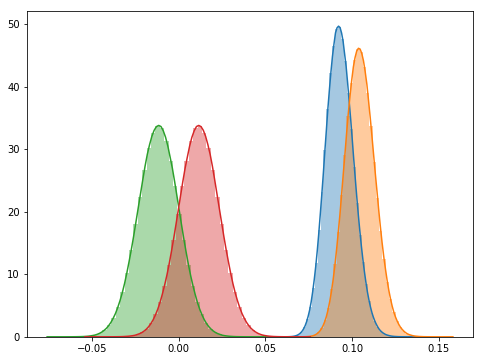

In [6]:
fig = plt.figure(figsize=(8, 6))
sns.distplot(pb['post_beta_A'], kde=True, rug=False, bins=50)
sns.distplot(pb['post_beta_B'], kde=True, rug=False, bins=50)
sns.distplot(ds['A_minus_B'], kde=True, rug=False, bins=50)
sns.distplot(ds['B_minus_A'], kde=True, rug=False, bins=50)

In [7]:
print(cs['A_more_than_B'])
print(cs['B_more_than_A'])

0.1606013
0.8393987
